# Bitcoin Returns - Time Series Analysis

A cryptocurrency (or crypto currency) is a digital asset designed to work as a medium of exchange wherein individual coin ownership records are stored in a ledger existing in a form of computerized database using strong cryptography to secure transaction records, to control the creation of additional coins, and to verify the transfer of coin ownership.It typically does not exist in physical form (like paper money) and is typically not issued by a central authority. Cryptocurrencies typically use decentralized control as opposed to centralized digital currency and central banking systems.
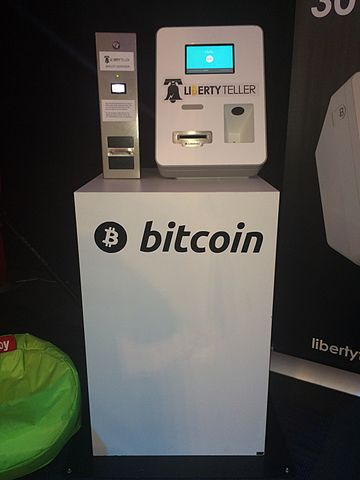

[Source: Wikipedia](https://en.wikipedia.org/wiki/Cryptocurrency)

Image by Martin E. Walder - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=35767746


# Contents

* [Some useful libraries](##Libraries)
* [Data collection](##Data-collection)
* [Visualization](##Visualization)
* [Bitcoin Returns Time Series Analysis](##Bitcoin-Returns-Time-Series-Analysis)
    * [Prices and Trading Volumes](###Prices-and-trading-volumes)
    * [Volatility](###Volatility)
    * [Stationarity](###Stationarity)
    * [Autocorrelation](###Autocorrelation)
    * [Distribution](###Distribution)

## Libraries

In [38]:
import os
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib import markers
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import jarque_bera,probplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import btc_lib
%matplotlib inline
os.chdir(os.getcwd())

## Data collection

Bitcoin (or other coins) historical data can be collected either via CoinBase or Yahoo finance. 
The function retrieving data from CoinBase needs to be inputted the name of the coin, the function retrieving data from Yahoo Finance needs to be inputted the ticker.

In [39]:
#scrape historical data from coinbase
btc_df=btc_lib.cb_hist_data_scrap('bitcoin',startdate='20140101',enddate='20200630')
btc_df.head()
#or alternatively yahoo finance:
#btc_df=btc_lib.yf_historical_data('BTC-USD',end_date=None, start_date=None,freq='Daily')

,Open,High,Low,Close,Volume,Market Cap,name,Market_Cap_in_bn,Volume_in_bn
Date,,,,,,,,,
2014-01-01,754.97,775.35,754.97,771.40,22489400,9403308145,bitcoin,9.403308,0.022489
2014-01-02,773.44,820.31,767.21,802.39,38489500,9781073921,bitcoin,9.781074,0.038490
2014-01-03,802.85,834.15,789.12,818.72,37810100,9980135396,bitcoin,9.980135,0.037810
2014-01-04,823.27,859.51,801.67,859.51,38005000,10477362437,bitcoin,10.477362,0.038005
2014-01-05,858.55,952.40,854.52,933.53,72898496,11379660685,bitcoin,11.379661,0.072898


## Visualization

### Prices and trading volumes

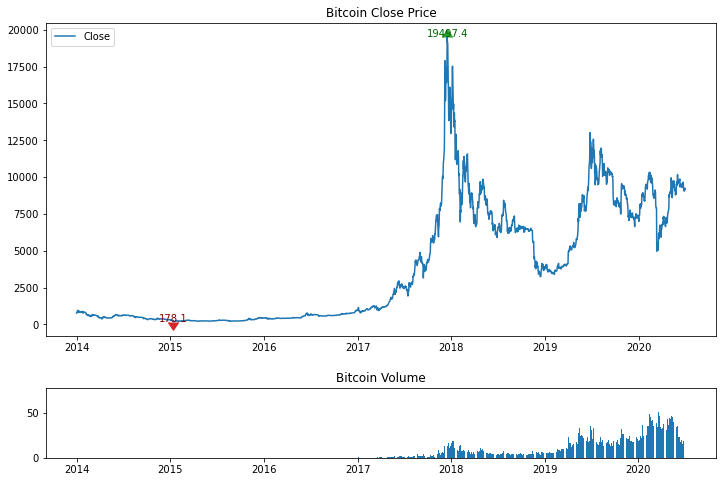

In [40]:
prices = btc_df['Close']
volumes = btc_df['Volume_in_bn']

# The top plot consisting of daily closing prices
top = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
top.plot(prices.index, prices, label='Close')
plt.title('Bitcoin Close Price')
plt.legend(loc=2)

close_max = max(btc_df['Close'])
close_max_pos = btc_df[btc_df['Close']==(close_max)].index
close_max_date = btc_df.loc[close_max_pos].index

close_min = min(btc_df['Close'])
close_min_pos = btc_df[btc_df['Close']==(close_min)].index
close_min_date = btc_df.loc[close_min_pos].index

plt.scatter(close_max_date, close_max, marker=markers.CARETUPBASE, color='tab:green', s=100, label='Peak')
plt.scatter(close_min_date, close_min, marker=markers.CARETDOWNBASE, color='tab:red', s=100, label='Trough')

plt.text(close_max_date, close_max, close_max, horizontalalignment='center', color='darkgreen')
plt.text(close_min_date, close_min, close_min, horizontalalignment='center', color='darkred')
# The bottom plot consisting of daily trading volume
bottom = plt.subplot2grid((4, 4), (3,0), rowspan=1, colspan=4)
bottom.bar(volumes.index, volumes)
plt.title('Bitcoin Volume')
plt.gcf().set_size_inches(12, 8)
plt.subplots_adjust(hspace=0.75)
plt.show()

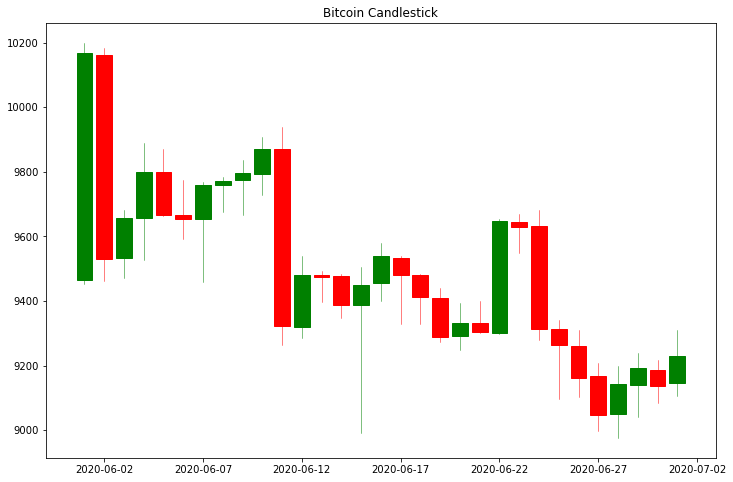

In [41]:
df_reset =btc_lib.cb_hist_data_scrap('bitcoin',startdate='20200601',enddate='20200630')
df_reset['Date']=df_reset.index.map(mdates.date2num)
df_reset.index = df_reset.index.map(mdates.date2num)
df_ohlc = df_reset[['Date','Open', 'High', 'Low', 'Close']]
figure, ax = plt.subplots(figsize = (12,8))
formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
candlestick_ohlc(ax,df_ohlc.values, width=0.8, colorup='green', colordown='red')
plt.title('Bitcoin Candlestick')
plt.show()


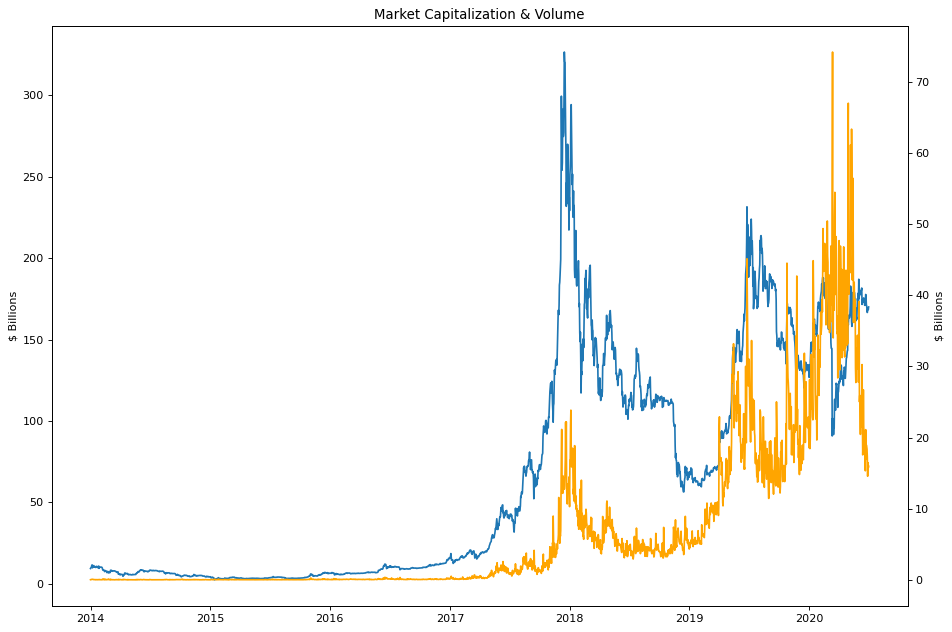

In [42]:
fig, ax1 = plt.subplots(dpi= 80)

color = 'tab:red'
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('$ Billions')
ax1.plot(btc_df.index,btc_df['Market_Cap_in_bn'])
ax1.tick_params(axis='y',rotation=0)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('$ Billions')
ax2.plot(btc_df.index,btc_df['Volume_in_bn'],color='orange')
ax2.tick_params(axis='y',rotation=0)

ax1.set_title('Market Capitalization & Volume')
plt.gcf().set_size_inches(12, 8)

fig.tight_layout()  
plt.show()

### Daily Returns

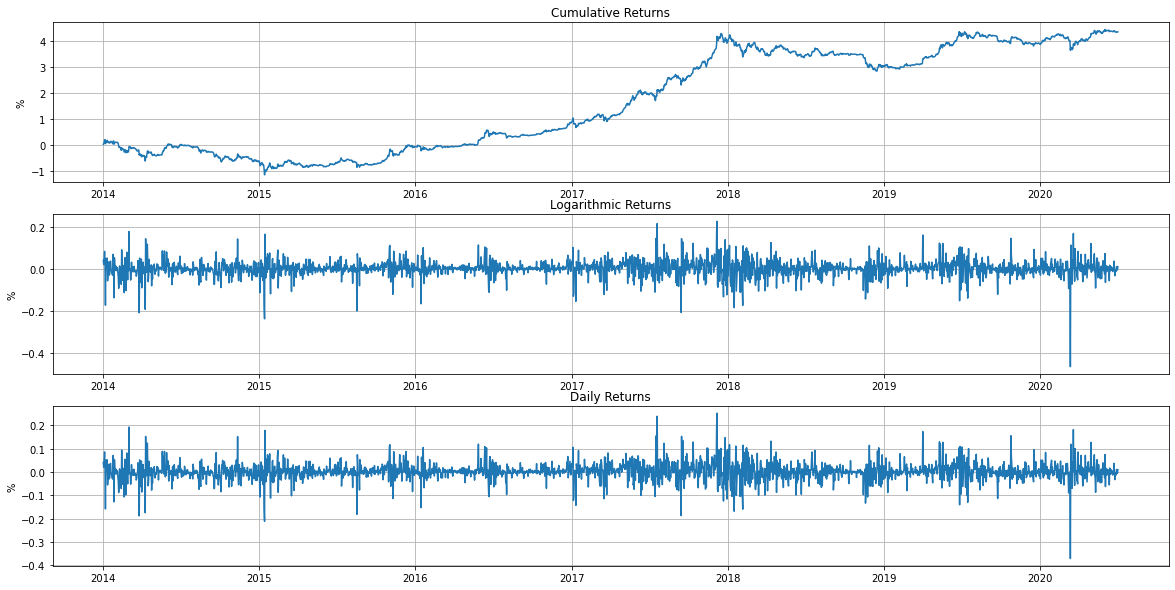

In [43]:
#add returns and logged returns to dataframe
daily_returns=btc_df['Close'].pct_change()
daily_returns.dropna(inplace=True)
log_returns= np.log(btc_df['Close']) - np.log(btc_df['Close'].shift(1))
log_returns.dropna(inplace=True)
cumulative_returns=daily_returns.cumsum()
cumulative_returns.dropna(inplace=True)

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1,figsize=(20, 10))
ax1.plot(cumulative_returns)
ax1.set_title('Cumulative Returns')
ax1.set_ylabel('%')
ax1.grid()

ax2.plot(log_returns)
ax2.set_title('Logarithmic Returns')
ax2.set_ylabel('%')
ax2.grid()

ax3.plot(daily_returns)
ax3.set_title('Daily Returns')
ax3.set_ylabel('%')
ax3.grid()


### Volatility

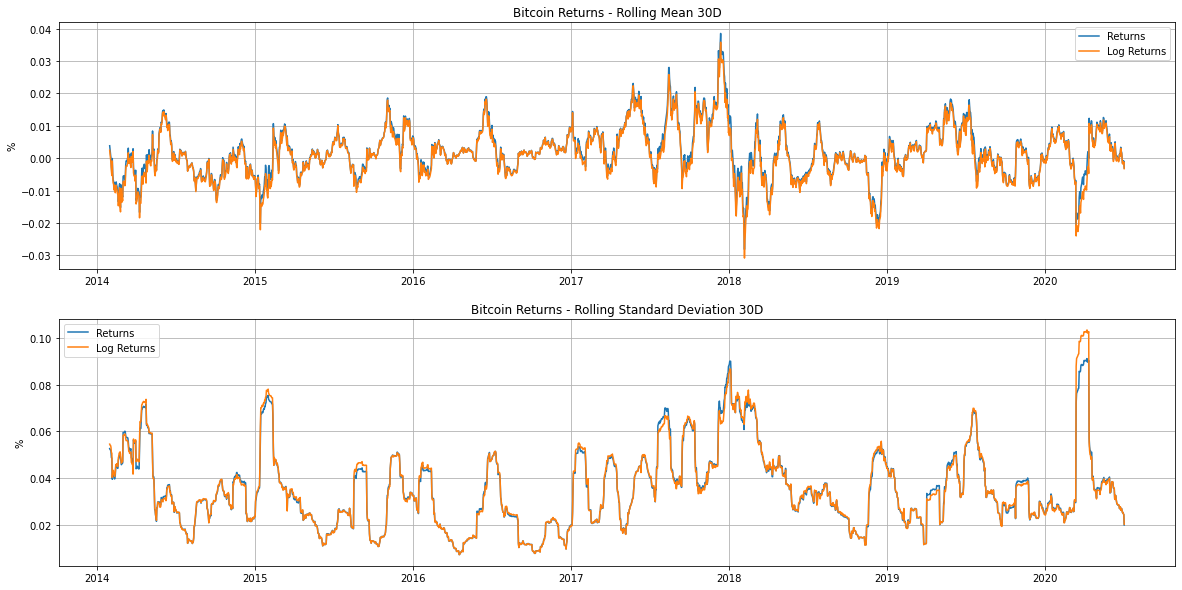

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(20, 10))
daily_returns_filled = daily_returns.asfreq('D', method='ffill') #to fill missing values due to public holidays etc
log_returns_filled=log_returns.asfreq('D', method='ffill')
ax1.plot(daily_returns_filled.rolling(window=30).mean())
ax1.plot(log_returns_filled.rolling(window=30).mean())
ax1.set_title('Bitcoin Returns - Rolling Mean 30D')
ax1.set_ylabel('%')
ax1.legend(['Returns','Log Returns'])
ax1.grid()


ax2.plot(daily_returns_filled.rolling(window=30).std())
ax2.plot(log_returns_filled.rolling(window=30).std())
ax2.set_title('Bitcoin Returns - Rolling Standard Deviation 30D')
ax2.set_ylabel('%')
ax2.legend(['Returns','Log Returns'])
ax2.grid()

### Stationarity

Stationarity is an assumption underlying many statistical procedures used in time series analysis. A stationary time series is one whose properties do not depend on the time at which the series is observed. There are a few ways to look for stationarity in time series data:

In [45]:
#AD-Fuller Test
btc_lib.is_stationary(daily_returns.dropna())

ADF Statistic: -14.699463
p-value: 0.000000
The series is stationary.
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


### Autocorrelation

In [46]:
#not autocorrelated
print("The autocorrelation of daily returns is %4.2f" %(daily_returns.autocorr()))

The autocorrelation of daily returns is -0.02


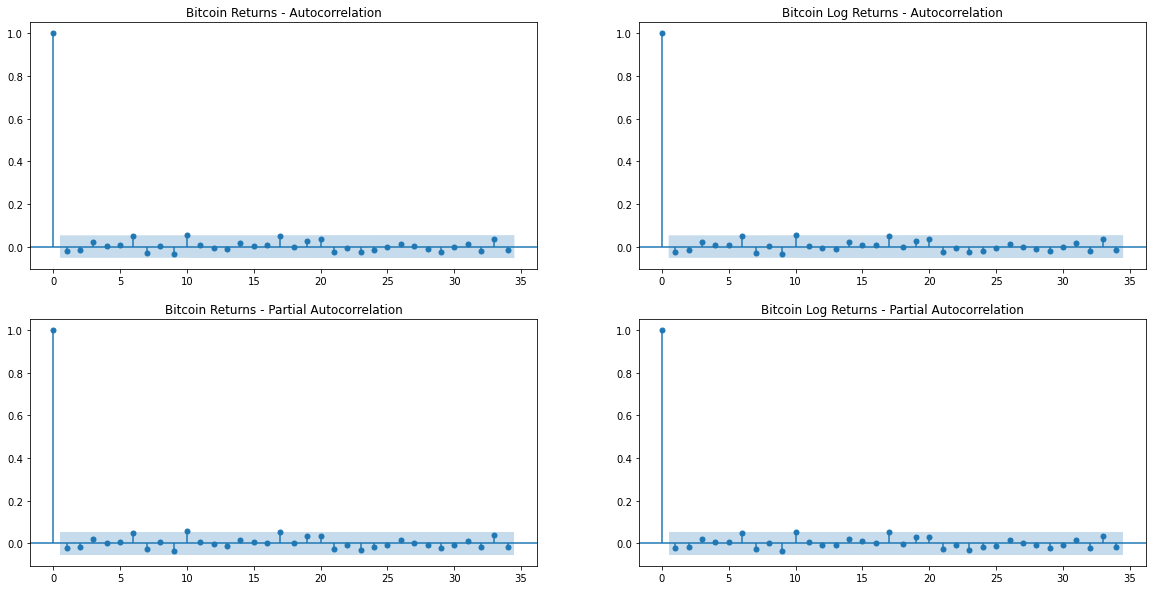

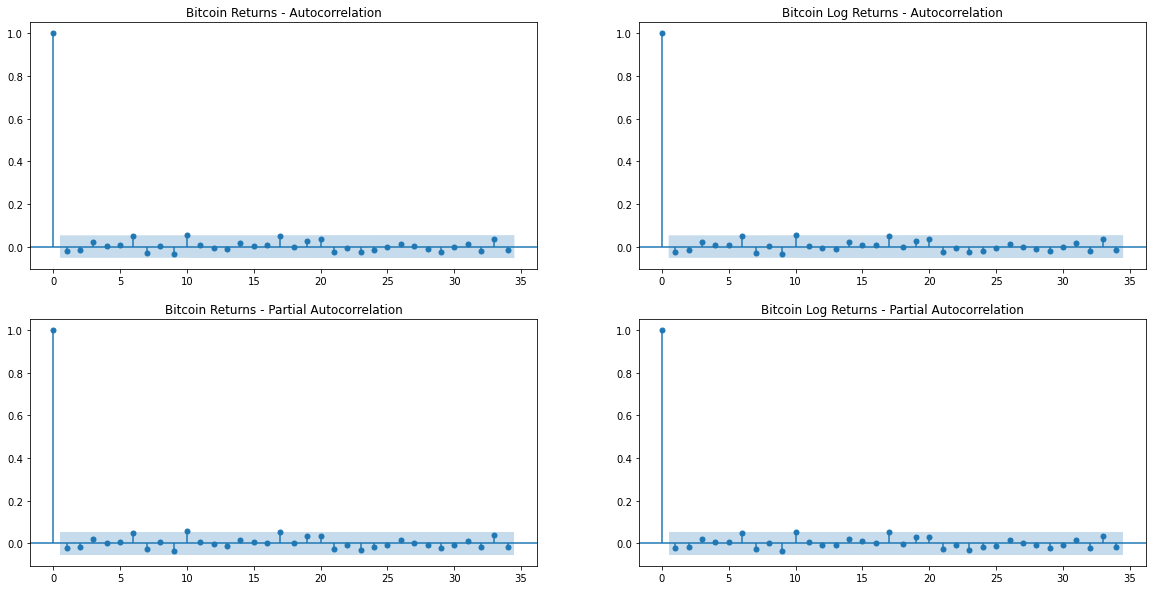

In [47]:
#can also be seen graphically. few lags that seem significant, low magnitude
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(20, 10))

plot_acf(daily_returns,alpha=0.01, title='Bitcoin Returns - Autocorrelation',ax=ax1)

plot_acf(log_returns,alpha=0.01,title='Bitcoin Log Returns - Autocorrelation',ax=ax2)

plot_pacf(daily_returns,alpha=0.01, title='Bitcoin Returns - Partial Autocorrelation',ax=ax3)

plot_pacf(log_returns,alpha=0.01, title='Bitcoin Log Returns - Partial Autocorrelation',ax=ax4)


### Distribution

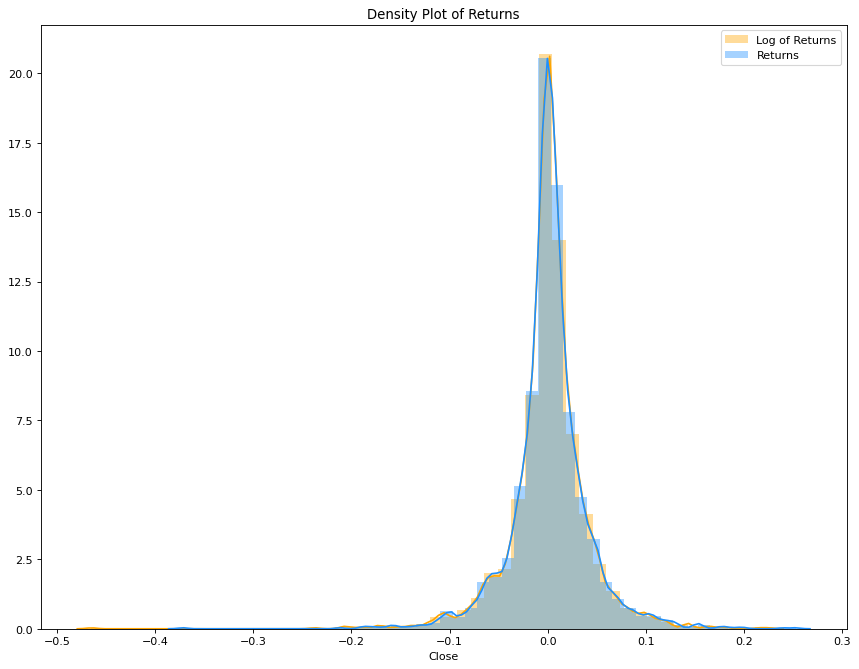

In [48]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(log_returns, color="orange", label="Log of Returns", hist=True)
sns.distplot(daily_returns, color="dodgerblue", label="Returns",hist=True)

# Decoration
plt.title('Density Plot of Returns')

plt.legend()

plt.show()


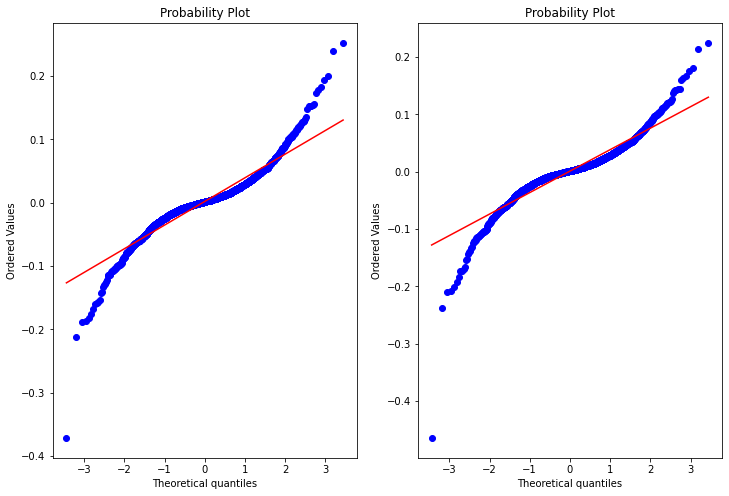

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,8))
probplot(daily_returns, dist='norm', plot=ax1)
probplot(log_returns, dist='norm', plot=ax2)
plt.show()

In [50]:
#Visualize  kurtosis, skewness
print("Daily Returns Distribution:")
btc_lib.skewness(daily_returns,ddof=0)
btc_lib.kurtosis(daily_returns,ddof=0)

print("-------------------")
print("Daily Log Returns Distribution:")
btc_lib.skewness(log_returns,ddof=0)
btc_lib.kurtosis(log_returns,ddof=0)

Daily Returns Distribution:
Skewness: -0.214120
Distribution is left skewed
Kurtosis: 11.135156
Distribution is leptokurtic
-------------------
Daily Log Returns Distribution:
Skewness: -0.916172
Distribution is left skewed
Kurtosis: 15.304393
Distribution is leptokurtic


15.304393403671737

In [51]:
print("Daily Returns Distribution:")
btc_lib.jb_test_is_normal(daily_returns, critical_level=0.01)
print("---------------------")
print("Daily Returns Distribution:")
btc_lib.jb_test_is_normal(log_returns, critical_level=0.01)

Daily Returns Distribution:
J_B Statistic: 6561.755623
p-value: 0.000000
The series is not normal.
---------------------
Daily Returns Distribution:
J_B Statistic: 15301.458365
p-value: 0.000000
The series is not normal.


## Other coins

In [52]:
coins=['bitcoin','ethereum']
df_list=[]
for c in coins:
    df=btc_lib.cb_hist_data_scrap(coin=c,startdate='20140101',enddate='20200831')
    df_list.append(df)
coins_df=pd.concat(df_list)
coins_df_subset=coins_df[['Close','name']]
coins_df_subset.reset_index(inplace=True)
coins_df_subset.set_index(['Date','name'],drop=True,inplace=True)
coins_df_subset=coins_df_subset.unstack()
coins_df_subset.dropna(inplace=True)
coins_df_subset.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

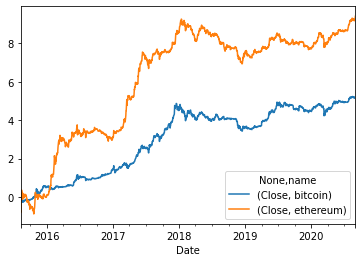

In [53]:
coins_df_subset.pct_change().cumsum().dropna().plot()

In [54]:
coins_df_subset

Close            
name         bitcoin    ethereum
Date                            
2015-08-07    279.58    2.770000
2015-08-08    261.00    0.753325
2015-08-09    265.08    0.701897
2015-08-10    264.47    0.708448
2015-08-11    270.39    1.070000
...              ...         ...
2020-08-28  11542.50  395.870000
2020-08-29  11506.87  399.920000
2020-08-30  11711.51  428.400000
2020-08-31  11680.82  435.080000
2020-09-01  11970.48  477.050000

[1853 rows x 2 columns]